# **Sentiment Analysis Ulasan Aplikasi SIGNAL**


> **Identitas Diri**



```
Nama: Farrel Paksi Aditya
Email: farrelpaksiaditya@gmail.com
```



---




Dalam proyek ini, saya menerapkan 3 skema pelatihan model dengan metode hybrid, yaitu penggunaan model **BERT: Indonesian RoBERTa Base Sentiment Classifier**, ini berguna dalam kasus Analisis Sentimen berbahasa Indonesia. Lalu, model Roberta tersebut digabung (hybrid) dengan 3 model Deep Learning untuk data sequence, yaitu LSTM, GRU, dan CNN. Untuk CNN sendiri digunakan karena model tersebut unggul dalam pemrosesan data spasial seperti gambar dalam Layer Convolution 2 Dimensi. Jika saya terapkan 1 Dimensi pada layer tersebut, apakah bisa?

Oleh karena itu, di sini saya coba uji performa nya dengan dipasangkan model Roberta. Berikut tabel skema pelatihan model untuk memperjelas strategi uji coba yang akan digunakan:



| No | Komponen | Skema 1 (Baseline / Paper) | Skema 2 (Optimasi Data) | Skema 3 (Komparasi Arsitektur) |
|----|----------|----------------------------|--------------------------|--------------------------------|
| 1 | Arsitektur Model | IndoRoBERTa + LSTM | IndoRoBERTa + GRU | IndoRoBERTa + CNN |
| 2 | Pre-trained Base (BERT/RoBERTa) | w11wo/indonesian-roberta-base-sentiment-classifier | w11wo/indonesian-roberta-base-sentiment-classifier | w11wo/indonesian-roberta-base-sentiment-classifier |
| 3 | Pembagian Data | 60% : 20% : 20% (Train : Val : Test) | 80% : 10% : 10% (Train : Val : Test) | 70% : 15% : 15% (Train : Val : Test) |
| 4 | Metode Pelabelan | Autolabel (ChatGPT Plus) + <br>Prompt Engineering – Strict Logic | Autolabel (ChatGPT Plus)<br>Prompt Engineering – Strict Logic | Autolabel (ChatGPT Plus)<br>Prompt Engineering – Strict Logic |
| 5 | Augmentasi Data | Synonym Replacement (Data train kelas minoritas) | Synonym Replacement (Data train kelas minoritas) | Synonym Replacement (Data train kelas minoritas) |
| 6 | Hyperparameter | Optimizer: AdamW<br>LR: 2e-5<br>Batch Size: 32<br>Epoch: 10 (Early Stop jika Akurasi > 94%) | Optimizer: AdamW<br>LR: 2e-5<br>Batch Size: 32<br>Epoch: 10 (Early Stop jika Akurasi > 94%) | Optimizer: AdamW<br>LR: 2e-5<br>Batch Size: 32<br>Epoch: 10 (Early Stop jika Akurasi > 94%) |


**Catatan:** Penggunaan AutoLabel di sini dengan teknik Prompt Engineering + ChatGPT Plus tidak disarankan untuk digunakan sebagai *Gold Standard* atau acuan pasti yang benar nilainya. Pelabelan yang benar memang dapat dilakukan oleh seorang ahli (manusia) dalam bidang bahasa atau seorang ahli bahasa.

In [1]:
!pip install nlpaug transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 13.0 MB/s eta 0:00:00


## **Data Gathering & Preparation**

In [37]:
# Import library pengolahan data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
from sklearn.utils import shuffle

import warnings, sys
warnings.filterwarnings('ignore')

# Import library pemodelan
import torch, transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertTokenizerFast, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [38]:
# Cek versi python, pytorch, dan transformers
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cu126
Transformers: 5.0.0


In [3]:
# Konfigurasi variabel global
# Runtime CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"

# Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# Load dataset yang sudah diberi label
# https://drive.google.com/file/d/1PH-9XSvK8fe-qqKmal2c_xSURXR4yFGc/view?usp=drive_link
df = pd.read_csv('https://drive.google.com/uc?id=1PH-9XSvK8fe-qqKmal2c_xSURXR4yFGc')
df

,review_text,label
0,mantap enggak harus ribet dtng ke kantor nya w...,Negatif
1,enggak bisa buat akun gara foto di ktp botak s...,Negatif
2,dokumen cepat dan aman,Positif
3,mantap cepat mudah,Positif
4,mudah cepat dan aman saya sudah sering menggun...,Positif
...,...,...
14995,pendaftaran cepat proses pengiriman lumayan hari,Positif
14996,proses cepat lebih mudah,Positif
14997,bermanfaat aplikasinya sudah beralih kesini un...,Netral
14998,lama banget dikirimnya harus mengadu dulu ke k...,Netral


## **Class Data Augmentation**

Augmentasi data di sini berguna untuk mengani kasus imbalanced data dengan menggunakan metode **Synonym Replacement**. Di mana model BERT digunakan untuk augmentasi data ini, yaitu dengan menggunakan repositori ini:

https://huggingface.co/cahya/bert-base-indonesian-522M

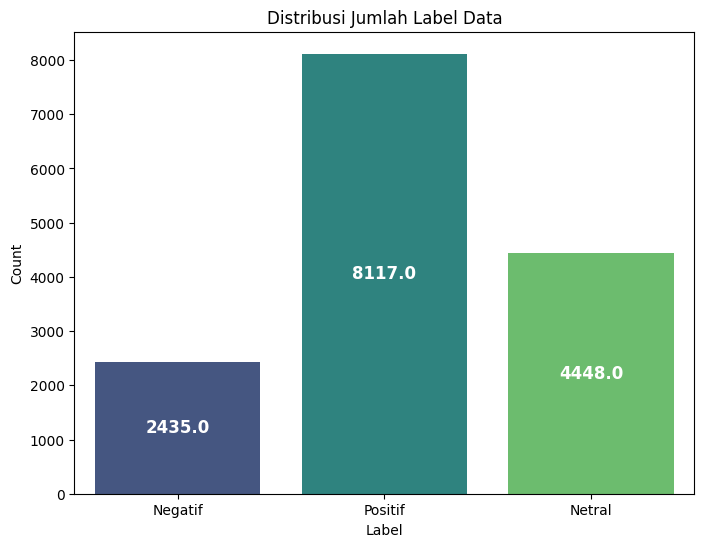

In [5]:
# Cek sebaran jumlah label pada data dengan bar chart
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')

# Jumlah label di tengah bar chart
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                ha='center', va='center', fontsize=12, color='white', fontweight='bold')

plt.title('Distribusi Jumlah Label Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [6]:
# Fungsi untuk mereplikasi 'convert_tokens_to_ids' untuk mengatasi
# permasalahan package transformers V5

def _convert_token_to_id(self, token):
    return self.convert_tokens_to_ids(token)

BertTokenizer._convert_token_to_id = _convert_token_to_id
BertTokenizerFast._convert_token_to_id = _convert_token_to_id

# Class untuk augmentasi data
class DataAugmenter:
    def __init__(self):
        # Gunakan BERT-base Indonesia untuk mencari sinonim yang kontekstual
        # cahya/bert-base-indonesian-522M
        self.aug = naw.ContextualWordEmbsAug(
            model_path='cahya/bert-base-indonesian-522M',
            action="substitute",
            device=device,
            batch_size=32
        )

    def augment_minority_class(self, df_train, label_column='label_encoded'):
        print("\nMemulai Proses Augmentasi (Synonym Replacement)...")

        # Cek Distribusi Awal
        counts = df_train[label_column].value_counts()
        target_count = counts.max() # Targetkan semua kelas jumlahnya sama dengan Mayoritas

        print("Distribusi Sebelum Augmentasi:")
        print(counts)
        print(f"Target jumlah per kelas: {target_count}")

        dfs_augmented = []

        # Loop per kelas
        for label_code in counts.index:
            df_class = df_train[df_train[label_column] == label_code]
            current_count = len(df_class)

            # Ambil labelnya
            label_name_str = df_class['label'].iloc[0] if 'label' in df_class.columns else None

            # Masukkan data asli ke list hasil
            dfs_augmented.append(df_class)

            # Jika kelas ini kurang dari target (Minoritas)
            if current_count < target_count:
                n_augment = target_count - current_count
                print(f"--> Kelas {label_name_str} (Minoritas): Generate {n_augment} data sintetis...")

                texts = df_class['review_text'].tolist()

                # Cek kalau teks kosong/sedikit
                if len(texts) > 0:
                    # Ambil sampel acak untuk dijadikan bahan augmentasi
                    source_texts = np.random.choice(texts, n_augment, replace=True)

                    # Proses Augmentasi (Batching)
                    augmented_results = []
                    batch_size = 32 # Proses per 32 kalimat/teks

                    # Loop sederhana untuk batching
                    for i in range(0, len(source_texts), batch_size):
                        batch = list(source_texts[i:i+batch_size])
                        try:
                            # Generate sinonim
                            aug_batch = self.aug.augment(batch)
                            augmented_results.extend(aug_batch)
                        except Exception as e:
                            print(f"Warning: Error pada batch {i} - {e}")

                    # Potong jika kelebihan
                    augmented_results = augmented_results[:n_augment]

                    # Buat DataFrame Sintetis
                    df_synthetic = pd.DataFrame({
                        'review_text': augmented_results,
                        label_column: label_code,
                        'label': label_name_str
                    })
                    dfs_augmented.append(df_synthetic)
            else:
                print(f"--> Kelas {label_code} ({label_name_str}): Mayoritas (Skip).")

        # Gabungkan Semua & Acak
        df_final = pd.concat(dfs_augmented).reset_index(drop=True)
        df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

        print("\nDistribusi SETELAH Augmentasi:")
        print(df_final[label_column].value_counts())

        return df_final

# Inisialisasikan
augmenter = DataAugmenter()

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.value.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.self.query.weight, cls.predictions.transform.dense.bias, cls.predictions.decoder.weight, bert.encoder.layer.*.attention.self.key.weight, cls.predictions.transform.LayerNorm.bias, cls.predictions.transform.dense.weight, cls.predictions.transform.LayerNorm.weight, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/204 [00:00<?, ?it/s]

In [7]:
# Mapping Label ke Angka (Encoding)
label_map = {'Negatif': 0, 'Netral': 1, 'Positif': 2}
df['label_encoded'] = df['label'].map(label_map)

# Buang data null jika ada
df = df.dropna(subset=['label_encoded', 'review_text'])
df['label_encoded'] = df['label_encoded'].astype(int)

print(f"Total Data Awal: {len(df)}")

Total Data Awal: 14934


## **Class Indonesian Roberta Feature Extractor (Arsitektur Model Hybrid)**

Indonesian Roberta di sini digunakan sebagai model yang bertugas untuk **mengekstraksi fitur** dari bentuk huruf ke dalam bentuk numerik atau representasi vektor. Repositori model nya dapat diakses di sini:

https://huggingface.co/w11wo/indonesian-roberta-base-sentiment-classifier

In [8]:
# Class untuk load atau proses data augmentasi setiap skema
class ProcessAugmentedData:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Tokenisasi
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ProcessAugmentedData(
        texts=df.review_text.to_numpy(),
        labels=df.label_encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

In [9]:
# Class untuk arsitektur model hybrid
class HybridRoberta(nn.Module):
    def __init__(self, model_name, n_classes, head_type, hidden_dim):
        super(HybridRoberta, self).__init__()

        self.head_type = head_type.lower()
        print(f"Menginisialisasi Model Hybrid: RoBERTa + {self.head_type.upper()}...")

        # Base Model (Feature Extractor)
        self.roberta = AutoModel.from_pretrained(model_name)

        # Freeze sebagian layer RoBERTa agar training lebih cepat & hemat memori (Opsional dan Kondisional)
        # Hapus komentarnya jika GPU Out of Memory
        # for param in self.roberta.parameters():
        #     param.requires_grad = False

        # Ukuran output RoBERTa base = 768
        self.roberta_dim = 768

        # Define Head (LSTM / GRU / CNN)
        if self.head_type == 'lstm':
            self.head = nn.LSTM(
                input_size=self.roberta_dim,
                hidden_size=hidden_dim,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            self.classifier = nn.Linear(hidden_dim * 2, n_classes) # *2 karena Bidirectional

        elif self.head_type == 'gru':
            self.head = nn.GRU(
                input_size=self.roberta_dim,
                hidden_size=hidden_dim,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)

        elif self.head_type == 'cnn':
            # CNN 1D untuk teks
            self.head = nn.Conv1d(
                in_channels=self.roberta_dim,
                out_channels=hidden_dim,
                kernel_size=3, # Filter size (melihat 3 kata sekaligus)
                padding=1
            )
            self.classifier = nn.Linear(hidden_dim, n_classes)

        else:
            raise ValueError("Tipe head harus 'lstm', 'gru', atau 'cnn'")

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask):
        # Feature Extraction dengan RoBERTa
        # output: (batch_size, seq_len, 768)
        roberta_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Masuk ke Head (Hybrid)
        if self.head_type in ['lstm', 'gru']:
            # LSTM/GRU Output: (batch, seq_len, hidden*2)
            output, _ = self.head(roberta_out)
            # Mean Pooling: Ambil rata-rata semua token output
            output = torch.mean(output, dim=1)

        elif self.head_type == 'cnn':
            # CNN butuh input (batch, channels, seq_len), lakukan permute
            # roberta_out: (batch, 768, seq_len)
            roberta_out = roberta_out.permute(0, 2, 1)

            output = self.head(roberta_out)
            # output: (batch, hidden_dim, seq_len)

            # Global Max Pooling (Ambil fitur paling menonjol)
            output = F.max_pool1d(output, kernel_size=output.shape[2])
            # output: (batch, hidden_dim, 1) -> Squeeze jadi (batch, hidden_dim)
            output = output.squeeze(2)

        # Klasifikasi
        output = self.dropout(output)
        return self.classifier(output)

In [10]:
# Fungsi untuk train dan evaluasi model
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [11]:
# Setup Tokenizer & DataLoader
MODEL_NAME = "w11wo/indonesian-roberta-base-sentiment-classifier"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128
BATCH_SIZE = 32

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## **Class Model Evaluator**

Model yang sudah dilatih akan diuji dan dievaluasi dengan data yang belum dilihat sama sekali oleh model (data test).

In [12]:
# Class untuk mengevaluasi serta menguji performa model hybrid
class ModelEvaluator:
    def __init__(self, device):
        self.device = device
        self.class_names = ['Negatif', 'Netral', 'Positif']

    def predict(self, model, data_loader):
        """
        Fungsi internal untuk melakukan prediksi pada seluruh data test
        """
        model = model.eval()
        predictions = []
        prediction_probs = []
        real_values = []

        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(self.device)
                attention_mask = d["attention_mask"].to(self.device)
                targets = d["targets"].to(self.device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                # Ambil probabilitas tertinggi sebagai prediksi
                _, preds = torch.max(outputs, dim=1)

                predictions.extend(preds)
                prediction_probs.extend(outputs)
                real_values.extend(targets)

        # Pindahkan ke CPU untuk diproses Scikit-Learn
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()

        return predictions, real_values

    def evaluate(self, model, data_loader, model_name="Model"):
        """
        Fungsi utama: Menjalankan evaluasi lengkap (Report + Confusion Matrix)
        """
        print(f"\n{'='*20} EVALUASI: {model_name} {'='*20}")

        # Lakukan Prediksi
        y_pred, y_test = self.predict(model, data_loader)

        # Hitung Akurasi, Precision, Recall, dan F1-Score
        # Hitung menggunakan weighted average karena imbalanced data
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"\n✅ Akurasi Final      : {acc*100:.2f}%")
        print(f"✅ Precision (Weighted): {prec*100:.2f}%")
        print(f"✅ Recall (Weighted)   : {rec*100:.2f}%")
        print(f"✅ F1-Score (Weighted) : {f1*100:.2f}%")

        # Print Classification Report (Precision, Recall, F1)
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

        # Plot Confusion Matrix
        self._plot_confusion_matrix(y_test, y_pred, model_name)

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        }

    def _plot_confusion_matrix(self, y_test, y_pred, model_name):
        """
        Fungsi privat untuk plot heatmap confusion matrix
        """
        cm = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(cm, index=self.class_names, columns=self.class_names)

        plt.figure(figsize=(6, 5))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.ylabel('Label Sebenarnya (True)')
        plt.xlabel('Prediksi Model (Predicted)')
        plt.show()

# Helper Function untuk Load Model
def load_trained_model(path, model_class, model_name_base, n_classes, head_type, hidden_dim, device):
    print(f"Loading weights from: {path}...")
    model = model_class(
        model_name=model_name_base,
        n_classes=n_classes,
        head_type=head_type,
        hidden_dim=hidden_dim
    )
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [13]:
# Inisialisasi Evaluator
evaluator = ModelEvaluator(device)

## **Skema Pemodelan 1: Hybrid Indonesian Roberta+LSTM**

### **Synonym Replacement - Data Augmentation**

In [15]:
# Pipeline untuk augmentasi data guna mengatasi imbalanced data pada skema 1
# Split data skema 1: 60:20:20
# df_temp untuk val dan test
df_train_s1, df_temp_s1 = train_test_split(
    df,
    test_size=0.4,
    random_state=RANDOM_SEED,
    stratify=df['label_encoded'] # Jaga proporsi label dengan stratify
)

# Bagi 50% df_temp
df_val_s1, df_test_s1 = train_test_split(
    df_temp_s1,
    test_size=0.5, # Bagi 2 dari sisa
    random_state=RANDOM_SEED,
    stratify=df_temp_s1['label_encoded'] # Jaga proporsi label dengan stratify
)

print(f"Data Train (60%) : {len(df_train_s1)} baris")
print(f"Data Val   (20%) : {len(df_val_s1)} baris")
print(f"Data Test  (20%) : {len(df_test_s1)} baris")

Data Train (60%) : 8960 baris
Data Val   (20%) : 2987 baris
Data Test  (20%) : 2987 baris


In [15]:
# Terapkan augmentasi data untuk skema 1
df_train_aug_s1 = augmenter.augment_minority_class(df_train_s1, label_column='label_encoded')


Memulai Proses Augmentasi (Synonym Replacement)...
Distribusi Sebelum Augmentasi:
label_encoded
2    4870
1    2629
0    1461
Name: count, dtype: int64
Target jumlah per kelas: 4870
--> Kelas 2 (Positif): Mayoritas (Skip).
--> Kelas Netral (Minoritas): Generate 2241 data sintetis...
--> Kelas Negatif (Minoritas): Generate 3409 data sintetis...

Distribusi SETELAH Augmentasi:
label_encoded
2    4870
0    4870
1    4870
Name: count, dtype: int64


In [16]:
# Verifikasi hasil augmentasi data pada skema 1
print("Data Asli vs Data Hasil Augmentasi (Sampel)")
print(df_train_aug_s1[['review_text', 'label_encoded']].head(5))

# Pastikan jumlah data Val dan Test Tidak Berubah
print(f"\nApakah Data Val berubah? {len(df_val_s1)} (Harus tetap)")
print(f"Apakah Data Test berubah? {len(df_test_s1)} (Harus tetap)")

Data Asli vs Data Hasil Augmentasi (Sampel)
                                         review_text  label_encoded
0  sekarang sudah jauh lebih aplikasinya pelayana...              2
1  monmaap tidak nih bayar susah tidak keluar kel...              0
2  bayar pajak sangat mudah dokumen diantar sampa...              2
3                yg puas 2 tahun sudah pakai 6 tahun              1
4  akun lama yang sudah register enggak bisa logi...              0

Apakah Data Val berubah? 2987 (Harus tetap)
Apakah Data Test berubah? 2987 (Harus tetap)


In [17]:
# Isi kolom label pada data hasil augmentasi
reverse_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
df_train_aug_s1['label'] = df_train_aug_s1['label_encoded'].map(reverse_map)

In [18]:
# Simpan hasil augmentasi data pada skema 1
df_train_aug_s1.to_csv('df_train_aug_s1.csv', index=False)

### **Training Model Indonesian Roberta + LSTM**

In [16]:
# Skema 1 pelatihan model
# Load Data Skema 1 yang sudah diaugmentasi
df_s1_train = pd.read_csv('df_train_aug_s1.csv')
print(f"Data Train Skema 1: {len(df_s1_train)}")

train_data_loader = create_data_loader(df_s1_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_s1, TOKENIZER, MAX_LEN, BATCH_SIZE)

# Inisialisasi Model HYBRID (Pilih HEAD 'lstm')
model = HybridRoberta(
    model_name=MODEL_NAME,
    n_classes=3,
    head_type='lstm',
    hidden_dim=256
)
model = model.to(device)

# Optimizer
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training Loop
print("\nStart Training Skema 1 (RoBERTa + LSTM)...")
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_accuracy = 0

# Target akurasi
target_accuracy = 0.94

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_s1_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model, val_data_loader, loss_fn, device, len(df_val_s1)
    )
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save Model Terbaik
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_skema1_lstm.bin')
        best_accuracy = val_acc
        print("=> Model Tersimpan!")

    # Early stopping untuk mencegah overfitting
    current_train_acc = train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc
    current_val_acc = val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc

    if current_train_acc > target_accuracy and current_val_acc > target_accuracy:
        print(f"\nTarget tercapai! Train: {current_train_acc:.4f}, Val: {current_val_acc:.4f} (> {target_accuracy})")
        print("Menghentikan pelatihan lebih awal...")
        torch.save(model.state_dict(), 'best_model_skema1_lstm.bin')
        print("=> Model Tersimpan!")
        break

print("Training Selesai.")

Data Train Skema 1: 14610
Menginisialisasi Model Hybrid: RoBERTa + LSTM...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Start Training Skema 1 (RoBERTa + LSTM)...
Epoch 1/10
Train loss 0.3858 accuracy 0.8514
Val   loss 0.1496 accuracy 0.9575
=> Model Tersimpan!
Epoch 2/10
Train loss 0.1863 accuracy 0.9323
Val   loss 0.0771 accuracy 0.9782
=> Model Tersimpan!
Epoch 3/10
Train loss 0.1152 accuracy 0.9626
Val   loss 0.0500 accuracy 0.9866
=> Model Tersimpan!

Target tercapai! Train: 0.9626, Val: 0.9866 (> 0.94)
Menghentikan pelatihan lebih awal...
=> Model Tersimpan!
Training Selesai.


### **Testing Model Indonesian Roberta + LSTM (Uji Performa)**

Loading weights from: best_model_skema1_lstm.bin...
Menginisialisasi Model Hybrid: RoBERTa + LSTM...


The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



==================== EVALUASI: Skema 1 (LSTM) ====================

✅ Akurasi Final      : 98.53%
✅ Precision (Weighted): 98.55%
✅ Recall (Weighted)   : 98.53%
✅ F1-Score (Weighted) : 98.53%

📊 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.94      0.98      0.96       487
      Netral       0.99      0.97      0.98       877
     Positif       1.00      1.00      1.00      1623

    accuracy                           0.99      2987
   macro avg       0.98      0.98      0.98      2987
weighted avg       0.99      0.99      0.99      2987



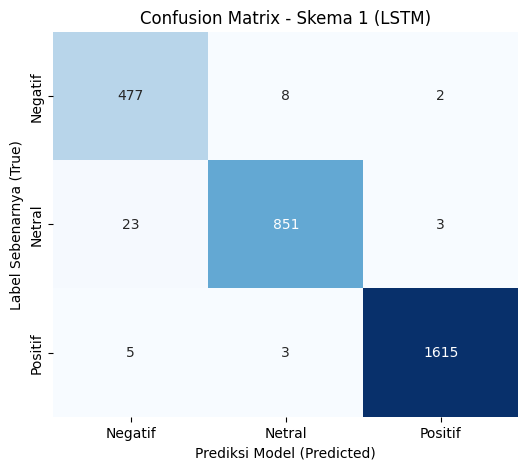

In [26]:
# Load Best Model Skema 1 (Model terbaik yang disimpan)
model_skema_1 = load_trained_model(
    path='best_model_skema1_lstm.bin',
    model_class=HybridRoberta,
    model_name_base=MODEL_NAME,
    n_classes=3,
    head_type='lstm',
    hidden_dim=256,
    device=device
)

# Uji performa model dengan data test
test_loader_s1 = create_data_loader(df_test_s1, TOKENIZER, MAX_LEN, BATCH_SIZE)
evaluate_s1 = evaluator.evaluate(model_skema_1, test_loader_s1, model_name="Skema 1 (LSTM)")

## **Skema Pemodelan 2: Hybrid Indonesian Roberta+GRU**

### **Synonym Replacement - Data Augmentation**

In [18]:
# Pipeline untuk augmentasi data guna mengatasi imbalanced data pada skema 2
# Split data skema 2: 80:10:10
# df_temp untuk val dan test
df_train_s2, df_temp_s2 = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['label_encoded'] # Jaga proporsi label dengan stratify
)

# Bagi 50% df_temp
df_val_s2, df_test_s2 = train_test_split(
    df_temp_s2,
    test_size=0.5, # Bagi 2 dari sisa
    random_state=RANDOM_SEED,
    stratify=df_temp_s2['label_encoded'] # Jaga proporsi label dengan stratify
)

print(f"Data Train (80%) : {len(df_train_s2)} baris")
print(f"Data Val   (10%) : {len(df_val_s2)} baris")
print(f"Data Test  (10%) : {len(df_test_s2)} baris")

Data Train (80%) : 11947 baris
Data Val   (10%) : 1493 baris
Data Test  (10%) : 1494 baris


In [22]:
# Terapkan augmentasi data untuk skema 2
df_train_aug_s2 = augmenter.augment_minority_class(df_train_s2, label_column='label_encoded')


Memulai Proses Augmentasi (Synonym Replacement)...
Distribusi Sebelum Augmentasi:
label_encoded
2    6493
1    3506
0    1948
Name: count, dtype: int64
Target jumlah per kelas: 6493
--> Kelas 2 (Positif): Mayoritas (Skip).
--> Kelas Netral (Minoritas): Generate 2987 data sintetis...
--> Kelas Negatif (Minoritas): Generate 4545 data sintetis...

Distribusi SETELAH Augmentasi:
label_encoded
1    6493
0    6493
2    6493
Name: count, dtype: int64


In [23]:
# Verifikasi hasil augmentasi data pada skema 2
print("Data Asli vs Data Hasil Augmentasi (Sampel)")
print(df_train_aug_s2[['review_text', 'label_encoded']].head(5))

# Pastikan jumlah data Val dan Test Tidak Berubah
print(f"\nApakah Data Val berubah? {len(df_val_s2)} (Harus tetap)")
print(f"Apakah Data Test berubah? {len(df_test_s2)} (Harus tetap)")

Data Asli vs Data Hasil Augmentasi (Sampel)
                                         review_text  label_encoded
0  allahmdulilah akhir bisa juga bayar pajak moto...              1
1  bagus enggak lagi sebaliknya pasca samsat yakn...              0
2              alhamdulillah puas dengan layanan nya              2
3                                    sangat membantu              2
4                                             mantap              2

Apakah Data Val berubah? 1493 (Harus tetap)
Apakah Data Test berubah? 1494 (Harus tetap)


In [24]:
# Isi kolom label pada data hasil augmentasi
reverse_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
df_train_aug_s2['label'] = df_train_aug_s2['label_encoded'].map(reverse_map)

In [25]:
# Simpan hasil augmentasi data pada skema 2
df_train_aug_s2.to_csv('df_train_aug_s2.csv', index=False)

### **Training Model Indonesian Roberta + GRU**

In [19]:
# Skema 2 pelatihan model
# Load Data Skema 2 yang sudah diaugmentasi
df_s2_train = pd.read_csv('df_train_aug_s2.csv')
print(f"Data Train Skema 2: {len(df_s2_train)}")

train_data_loader = create_data_loader(df_s2_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_s2, TOKENIZER, MAX_LEN, BATCH_SIZE)

# Inisialisasi Model HYBRID (Pilih HEAD 'gru')
model = HybridRoberta(
    model_name=MODEL_NAME,
    n_classes=3,
    head_type='gru',
    hidden_dim=256
)
model = model.to(device)

# Optimizer
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training Loop
print("\nStart Training Skema 2 (RoBERTa + GRU)...")
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_accuracy = 0

# Target akurasi
target_accuracy = 0.94

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_s2_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model, val_data_loader, loss_fn, device, len(df_val_s2)
    )
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save Model Terbaik
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_skema2_gru.bin')
        best_accuracy = val_acc
        print("=> Model Tersimpan!")

    # Early stopping untuk mencegah overfitting
    current_train_acc = train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc
    current_val_acc = val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc

    if current_train_acc > target_accuracy and current_val_acc > target_accuracy:
        print(f"\nTarget tercapai! Train: {current_train_acc:.4f}, Val: {current_val_acc:.4f} (> {target_accuracy})")
        print("Menghentikan pelatihan lebih awal...")
        torch.save(model.state_dict(), 'best_model_skema2_gru.bin')
        print("=> Model Tersimpan!")
        break

print("Training Selesai.")

Data Train Skema 2: 19479
Menginisialisasi Model Hybrid: RoBERTa + GRU...


The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Start Training Skema 2 (RoBERTa + GRU)...
Epoch 1/10
Train loss 0.3423 accuracy 0.8635
Val   loss 0.0571 accuracy 0.9859
=> Model Tersimpan!
Epoch 2/10
Train loss 0.1642 accuracy 0.9398
Val   loss 0.0443 accuracy 0.9886
=> Model Tersimpan!
Epoch 3/10
Train loss 0.1050 accuracy 0.9662
Val   loss 0.0459 accuracy 0.9879

Target tercapai! Train: 0.9662, Val: 0.9879 (> 0.94)
Menghentikan pelatihan lebih awal...
=> Model Tersimpan!
Training Selesai.


### **Testing Model Indonesian Roberta + GRU (Uji Performa)**

Loading weights from: best_model_skema2_gru.bin...
Menginisialisasi Model Hybrid: RoBERTa + GRU...


The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



==================== EVALUASI: Skema 2 (GRU) ====================

✅ Akurasi Final      : 98.66%
✅ Precision (Weighted): 98.69%
✅ Recall (Weighted)   : 98.66%
✅ F1-Score (Weighted) : 98.67%

📊 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.98      0.97       244
      Netral       0.99      0.97      0.98       438
     Positif       1.00      1.00      1.00       812

    accuracy                           0.99      1494
   macro avg       0.98      0.98      0.98      1494
weighted avg       0.99      0.99      0.99      1494



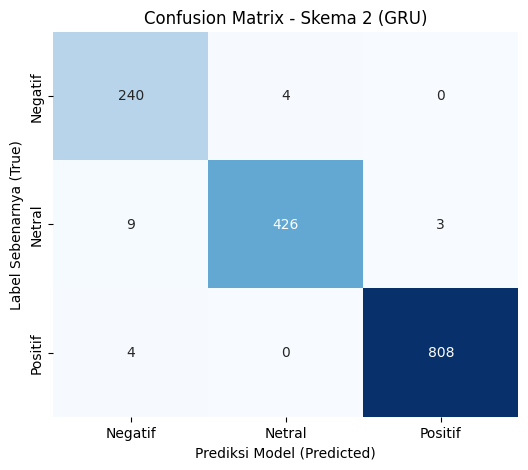

In [27]:
# Load Best Model Skema 2 (Model terbaik yang disimpan)
model_skema_2 = load_trained_model(
    path='best_model_skema2_gru.bin',
    model_class=HybridRoberta,
    model_name_base=MODEL_NAME,
    n_classes=3,
    head_type='gru',
    hidden_dim=256,
    device=device
)

# Uji performa model dengan data test
test_loader_s2 = create_data_loader(df_test_s2, TOKENIZER, MAX_LEN, BATCH_SIZE)
evaluate_s2 = evaluator.evaluate(model_skema_2, test_loader_s2, model_name="Skema 2 (GRU)")

## **Skema Pemodelan 3: Hybrid Indonesian Roberta+CNN**

### **Synonym Replacement - Data Augmentation**

In [21]:
# Pipeline untuk augmentasi data guna mengatasi imbalanced data pada skema 3
# Split data skema 3: 70:15:15
# df_temp untuk val dan test
df_train_s3, df_temp_s3 = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=df['label_encoded'] # Jaga proporsi label dengan stratify
)

# Bagi 50% df_temp
df_val_s3, df_test_s3 = train_test_split(
    df_temp_s3,
    test_size=0.5, # Bagi 2 dari sisa
    random_state=RANDOM_SEED,
    stratify=df_temp_s3['label_encoded'] # Jaga proporsi label dengan stratify
)

print(f"Data Train (70%) : {len(df_train_s3)} baris")
print(f"Data Val   (15%) : {len(df_val_s3)} baris")
print(f"Data Test  (15%) : {len(df_test_s3)} baris")

Data Train (70%) : 10453 baris
Data Val   (15%) : 2240 baris
Data Test  (15%) : 2241 baris


In [29]:
# Terapkan augmentasi data untuk skema 3
df_train_aug_s3 = augmenter.augment_minority_class(df_train_s3, label_column='label_encoded')


Memulai Proses Augmentasi (Synonym Replacement)...
Distribusi Sebelum Augmentasi:
label_encoded
2    5682
1    3067
0    1704
Name: count, dtype: int64
Target jumlah per kelas: 5682
--> Kelas 2 (Positif): Mayoritas (Skip).
--> Kelas Netral (Minoritas): Generate 2615 data sintetis...
--> Kelas Negatif (Minoritas): Generate 3978 data sintetis...

Distribusi SETELAH Augmentasi:
label_encoded
2    5682
1    5682
0    5682
Name: count, dtype: int64


In [30]:
# Verifikasi hasil augmentasi data pada skema 3
print("Data Asli vs Data Hasil Augmentasi (Sampel)")
print(df_train_aug_s3[['review_text', 'label_encoded']].head(5))

# Pastikan jumlah data Val dan Test Tidak Berubah
print(f"\nApakah Data Val berubah? {len(df_val_s3)} (Harus tetap)")
print(f"Apakah Data Test berubah? {len(df_test_s3)} (Harus tetap)")

Data Asli vs Data Hasil Augmentasi (Sampel)
                                         review_text  label_encoded
0       mantap sangat membantu tidak harus ke samsat              2
1  pengiriman tidak ada pilihan lain lebih murah ...              2
2                        beberapa minggu sudah tamat              1
3  sangat rekomendasi sekal tanpa harus pulang ke...              0
4                              paling ramai saat itu              1

Apakah Data Val berubah? 2240 (Harus tetap)
Apakah Data Test berubah? 2241 (Harus tetap)


In [31]:
# Isi kolom label pada data hasil augmentasi
reverse_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
df_train_aug_s3['label'] = df_train_aug_s3['label_encoded'].map(reverse_map)

In [32]:
# Simpan hasil augmentasi data pada skema 3
df_train_aug_s3.to_csv('df_train_aug_s3.csv', index=False)

### **Training Model Indonesian Roberta + CNN**

In [22]:
# Skema 3 pelatihan model
# Load Data Skema 3 yang sudah diaugmentasi
df_s3_train = pd.read_csv('df_train_aug_s3.csv')
print(f"Data Train Skema 3: {len(df_s3_train)}")

train_data_loader = create_data_loader(df_s3_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_s3, TOKENIZER, MAX_LEN, BATCH_SIZE)

# Inisialisasi Model HYBRID (Pilih HEAD 'cnn')
model = HybridRoberta(
    model_name=MODEL_NAME,
    n_classes=3,
    head_type='cnn',
    hidden_dim=256
)
model = model.to(device)

# Optimizer
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training Loop
print("\nStart Training Skema 3 (RoBERTa + CNN)...")
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_accuracy = 0

# Target akurasi
target_accuracy = 0.94

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_s3_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model, val_data_loader, loss_fn, device, len(df_val_s3)
    )
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save Model Terbaik
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_skema3_cnn.bin')
        best_accuracy = val_acc
        print("=> Model Tersimpan!")

    # Early stopping untuk mencegah overfitting
    current_train_acc = train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc
    current_val_acc = val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc

    if current_train_acc > target_accuracy and current_val_acc > target_accuracy:
        print(f"\nTarget tercapai! Train: {current_train_acc:.4f}, Val: {current_val_acc:.4f} (> {target_accuracy})")
        print("Menghentikan pelatihan lebih awal...")
        torch.save(model.state_dict(), 'best_model_skema3_cnn.bin')
        print("=> Model Tersimpan!")
        break

print("Training Selesai.")

Data Train Skema 3: 17046
Menginisialisasi Model Hybrid: RoBERTa + CNN...


The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Start Training Skema 3 (RoBERTa + CNN)...
Epoch 1/10
Train loss 0.3585 accuracy 0.8563
Val   loss 0.0851 accuracy 0.9719
=> Model Tersimpan!
Epoch 2/10
Train loss 0.1747 accuracy 0.9361
Val   loss 0.0524 accuracy 0.9835
=> Model Tersimpan!
Epoch 3/10
Train loss 0.1068 accuracy 0.9658
Val   loss 0.0501 accuracy 0.9866
=> Model Tersimpan!

Target tercapai! Train: 0.9658, Val: 0.9866 (> 0.94)
Menghentikan pelatihan lebih awal...
=> Model Tersimpan!
Training Selesai.


### **Testing Model Indonesian Roberta + CNN (Uji Performa)**

Loading weights from: best_model_skema3_cnn.bin...
Menginisialisasi Model Hybrid: RoBERTa + CNN...


The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.query.weight, embeddings.position_embeddings.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.key.weight, embeddings.word_embeddings.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.dense.weight, embeddings.LayerNorm.weight, embeddings.token_type_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: w11wo/indonesian-roberta-base-sentiment-classifier
Key                             | Status     | 
--------------------------------+------------+-
classifier.dense.weight         | UNEXPECTED | 
classifier.out_proj.bias        | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | UNEXPECTED | 
classifier.out_proj.weight      | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



==================== EVALUASI: Skema 3 (CNN) ====================

✅ Akurasi Final      : 98.75%
✅ Precision (Weighted): 98.76%
✅ Recall (Weighted)   : 98.75%
✅ F1-Score (Weighted) : 98.75%

📊 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.98      0.97       365
      Netral       0.99      0.98      0.98       658
     Positif       1.00      0.99      0.99      1218

    accuracy                           0.99      2241
   macro avg       0.98      0.99      0.98      2241
weighted avg       0.99      0.99      0.99      2241



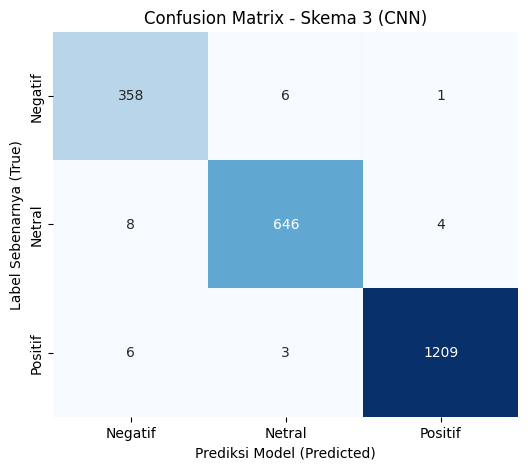

In [28]:
# Load Best Model Skema 3 (Model terbaik yang disimpan)
model_skema_3 = load_trained_model(
    path='best_model_skema3_cnn.bin',
    model_class=HybridRoberta,
    model_name_base=MODEL_NAME,
    n_classes=3,
    head_type='cnn',
    hidden_dim=256,
    device=device
)

# Uji performa model dengan data test
test_loader_s3 = create_data_loader(df_test_s3, TOKENIZER, MAX_LEN, BATCH_SIZE)
evaluate_s3 = evaluator.evaluate(model_skema_3, test_loader_s3, model_name="Skema 3 (CNN)")

## **Perbandingan Performa Model Hybrid**

Mengukur performa ketiga skema model hybrid dengan bar chart. Model hybrid terbaik akan dipilih sebagai kandidat inference (uji komentar atau ulasan langsung dari pengguna).

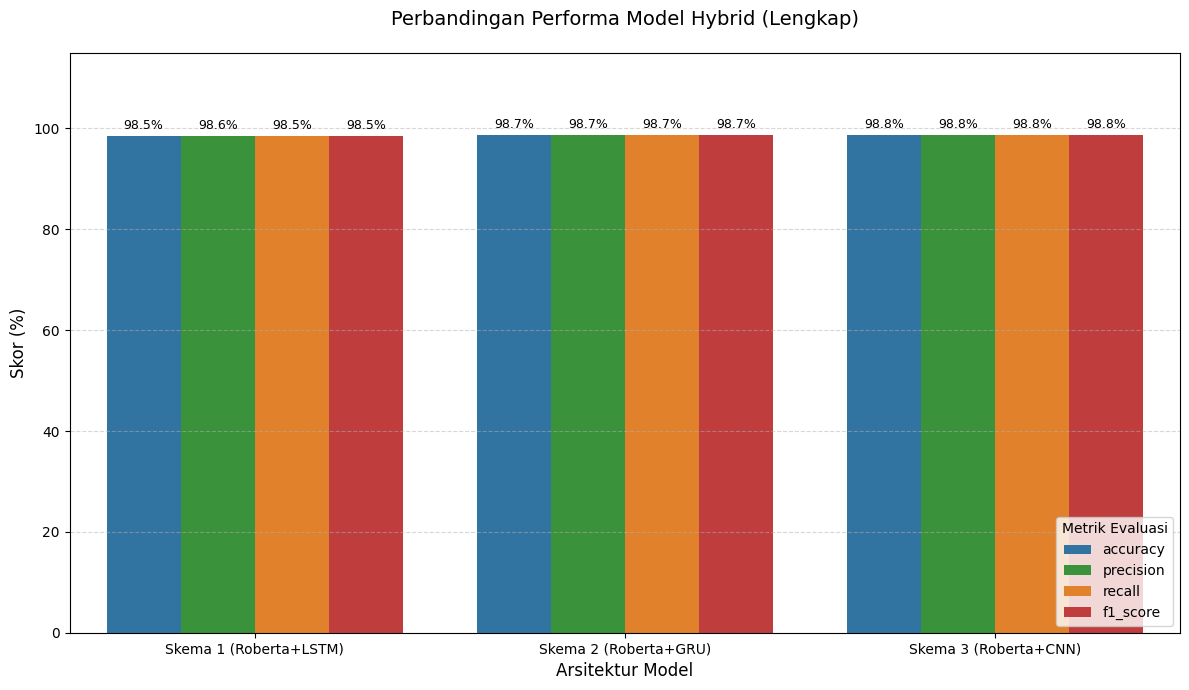

In [45]:
# Nilai akurasi, precision, recall, dan f1-score dari evaluasi model
results_data = [
    evaluate_s1,
    evaluate_s2,
    evaluate_s3
]

model_names = [
    "Skema 1 (Roberta+LSTM)",
    "Skema 2 (Roberta+GRU)",
    "Skema 3 (Roberta+CNN)"
]

# Buat dataframe untuk plot nilai akurasi
df_results = pd.DataFrame(results_data)
df_results['Model'] = model_names

# Ubah format angka ke persen
cols_to_multiply = ['accuracy', 'precision', 'recall', 'f1_score']
df_results[cols_to_multiply] = df_results[cols_to_multiply] * 100

# Format melt untuk panjang dataframe
df_melted = df_results.melt(
    id_vars="Model",
    var_name="Metrik",
    value_name="Skor"
)

# Plot grouped bar chart
palette = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_melted,
    x='Model',
    y='Skor',
    hue='Metrik',
    palette=palette
)

# Konfigurasi label di atas bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

# Kustomisasi tampilan grouped bar chart
plt.title('Perbandingan Performa Model Hybrid (Lengkap)', fontsize=14, pad=20)
plt.xlabel('Arsitektur Model', fontsize=12)
plt.ylabel('Skor (%)', fontsize=12)
plt.ylim(0, 115)
plt.legend(title='Metrik Evaluasi', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [46]:
# Tampilkan dataframe hasil evaluasi 3 skema hybrid model
df_results.set_index('Model')
df_results

,accuracy,precision,recall,f1_score,Model
0,98.526950,98.553644,98.526950,98.532948,Skema 1 (Roberta+LSTM)
1,98.661312,98.687037,98.661312,98.666535,Skema 2 (Roberta+GRU)
2,98.750558,98.759739,98.750558,98.753424,Skema 3 (Roberta+CNN)
